In [1]:
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
import ephem
from matplotlib import pyplot as plt
import pandas as pd
import math
import xarray as xr
import numpy as np
import glob

In [2]:
import scipy

In [3]:
# some good notes about radiation schemes
# https://repository.library.noaa.gov/view/noaa/49705

# good radiation notes that simplify much of hte petty book
# https://www.e-education.psu.edu/meteo300/node/784

In [4]:
ds = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/interpsond/sond_by_pressure2/all_sondes_withq_1h.nc")
ds = ds.rename({"bar_pres":"pressure"})

In [5]:
ceres_aod = xr.open_dataset("/global/homes/r/rudisill/CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20000301-20231130.nc").ini_aod55_daily.isel(lat=1,lon=0)

In [6]:
ceres_aod_sail = ceres_aod.sel(time=slice("2021-09-01", "2023-06-15"))

In [7]:
#ceres_aod_sail.to_netcdf("/global/homes/r/rudisill/gshare2/rrtmg_shared/ceres_aod55nm.nc")

In [8]:
aod = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/aod/ftp.archive.arm.gov/rudisillw2/242085/*.nc")

In [9]:
def cdf_match(source, template):
    """
    Adjust the values of 'source' so that its histogram matches that of 'template'.
    
    Parameters:
    source : array-like
        The data to be transformed.
    template : array-like
        The data that provides the target histogram.
    
    Returns:
    matched : ndarray
        The transformed data.
    """
    source = np.asarray(source)
    template = np.asarray(template)

    # Sort both datasets
    sorted_source = np.sort(source)
    sorted_template = np.sort(template)

    # Calculate the CDFs
    cdf_source = np.linspace(0, 1, len(sorted_source))
    cdf_template = np.linspace(0, 1, len(sorted_template))

    # Interpolate the values
    interp_values = np.interp(cdf_source, cdf_template, sorted_template)

    # Create a mapping from the source data to the interpolated values
    source_sorted_indices = np.argsort(source)
    matched = np.zeros_like(source)
    matched[source_sorted_indices] = interp_values

    return matched


In [10]:
import numpy as np

def calculate_angstrom_exponent(aod1, lambda1, aod2, lambda2):
    """
    Calculate the Ångström exponent.
    
    Parameters:
    aod1 : float
        AOD at wavelength lambda1.
    lambda1 : float
        Wavelength 1 in nanometers.
    aod2 : float
        AOD at wavelength lambda2.
    lambda2 : float
        Wavelength 2 in nanometers.
    
    Returns:
    alpha : float
        The Ångström exponent.
    """
    alpha = -np.log(aod1 / aod2) / np.log(lambda1 / lambda2)
    return alpha

def interpolate_aod(aod1, lambda1, aod2, lambda2, lambda_target):
    """
    Interpolate AOD to the target wavelength.
    
    Parameters:
    aod1 : float
        AOD at wavelength lambda1.
    lambda1 : float
        Wavelength 1 in nanometers.
    aod2 : float
        AOD at wavelength lambda2.
    lambda2 : float
        Wavelength 2 in nanometers.
    lambda_target : float
        Target wavelength in nanometers.
    
    Returns:
    aod_target : float
        Interpolated AOD at the target wavelength.
    """
    alpha = calculate_angstrom_exponent(aod1, lambda1, aod2, lambda2)
    aod_target = aod1 * (lambda_target / lambda1) ** -alpha
    return aod_target

# Example usage
aod_550 = interpolate_aod(aod.aod_500, 500, aod.aod_675, 675, 550)



In [11]:
ceres_matched = cdf_match(ceres_aod_sail.values, aod_550.values)

### do CDF matching of the CERES AOD data 

In [12]:
# _=aod_550.plot.hist(bins=30, histtype='step', density=True, color='red')
# _=ceres_aod_sail.plot.hist(bins=30, histtype='step', density=True, color='blue')
# plt.hist(ceres_matched, bins=30, histtype='step', density=True, color='green')

In [13]:
def calculate_aod_profile(column_aod, num_level, scale_height=.1):
    """
    Calculate the AOD profile given a column AOD and the number of atmospheric levels.
    
    Parameters:
    column_aod : float
        The total column AOD at 550 nm.
    num_levels : int
        The number of atmospheric levels.
    
    Returns:
    aod_profile : ndarray
        The AOD at each atmospheric level.
    """
    # Example: using an exponential decay profile
    # Generate an altitude array (assuming equal spacing)
    altitudes = np.linspace(0, 1, num_level)
    
    # Define a scale height for the exponential profile
#    scale_height = 0.1  
    
    # Calculate the exponential profile
    profile = np.exp(-altitudes / scale_height)
    
    # Normalize the profile
    normalized_profile = profile / np.sum(profile)
    
    # Scale by the column AOD
    aod_profile = normalized_profile * column_aod
    
    return aod_profile

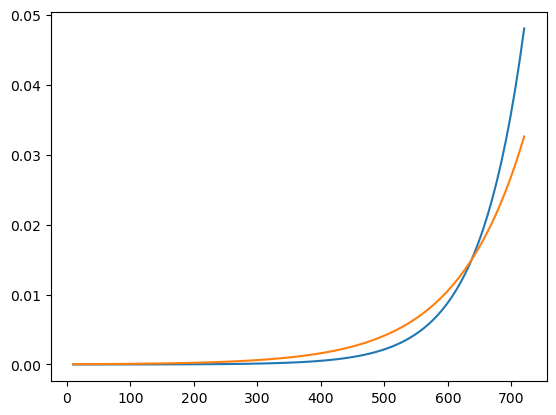

In [14]:
plt.plot(np.linspace(720,10,100), calculate_aod_profile(.5, 100))
plt.plot(np.linspace(720,10,100), calculate_aod_profile(.5, 100, .15))

In [16]:
albedo_wsa_vis = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_wsa_vis.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_wsa_vis"])
albedo_wsa_nir = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_wsa_nir.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_wsa_nir"])
albedo_bsa_vis = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_bsa_vis.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_bsa_vis"])
albedo_bsa_nir = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/clean_data/modis_albedo/albedo_bsa_nir.csv", parse_dates=True, index_col=0, header=0, names=["time", "albedo_bsa_nir"])
albedo_df = pd.concat([albedo_wsa_vis, albedo_wsa_nir, albedo_bsa_vis, albedo_bsa_nir], axis=1)

In [17]:
albedo_ds = xr.Dataset(albedo_df.reindex(ds.time).interpolate()).rename({"dim_0":"time"})

In [18]:
# albedo = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/daily_qc_albedo.csv", index_col=0, parse_dates=True)
# albedo.index.name = 'time'
# albedo = xr.Dataset(albedo)

In [19]:
#ozone=xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/bldr_aerosol_sondes.nc")
# ozone=ozone.sortby("time")
# ozone_resampled_sail_period = ozone.isel(time=slice(1980,-1)).drop_duplicates("time").resample(time="1h").interpolate("linear").o3
# ozone_resampled_sail_period = ozone_resampled_sail_period.where(ozone_resampled_sail_period<15).bfill(dim='pressure')
# ozone_resampled_sail_period.to_netcdf("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/bldr_aerosol_sondes_interpd.nc")

In [20]:
ozone_resampled_sail_period = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/bldr_aerosol_sondes_interpd.nc")

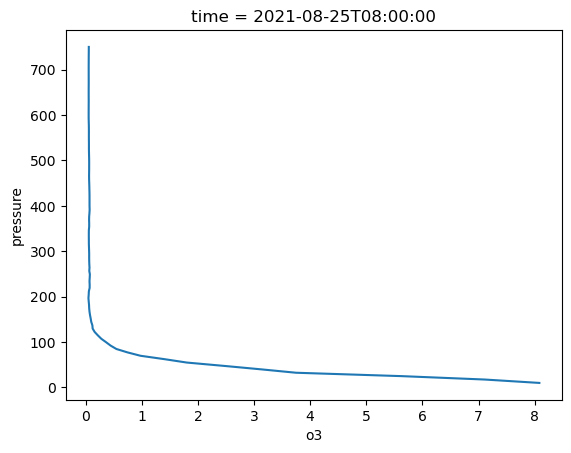

In [21]:
ozone_resampled_sail_period.o3.isel(time=200).plot(y='pressure')

In [22]:
#ozone_resampled_sail_period.reindex(time=ds.time).ffill(dim="time").plot(x='time')

In [23]:
ds['o3'] = xr.DataArray(data=ozone_resampled_sail_period.o3.reindex(time=ds.time).values[:,::-1],
             dims=["time", "level"],
             coords=ds.coords)

In [24]:
def calculate_solar_zenith_cosine(lat, lon, datetime_obj):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

### Read Ozone Data ... 
Here we are reading ozone data from the NOAA global monitoring lab 

here: https://gml.noaa.gov/ozwv/ozsondes/index.html

This is just looking at one day from April 2022. maybe it is worth looking at the actual ozone for that particular time 

In [25]:
# o3 = pd.read_csv("/global/u1/r/rudisill/ozone_profile_0422_bldr.csv")
# o3=o3.sort_values(by="Press_hpa")

# # interpolate it to a standard pressure grid
# # the actual pressure levels change a little bit from day to day
# # but most of the ozone is up high so this prob doesn't matter 
# o3_interp = np.interp(np.linspace(10, 750, 100), o3.Press_hpa, o3.Ozone_ppmv)[::-1] * 10E-6

In [26]:
ds.q.attrs = {"units":"kg/kg", 'quantity':'specific humidity'}

In [27]:
ds.pwat.attrs = {"units":"cm", 'quantity':'precipitable water'}

In [28]:
ds.o3.attrs = {"units":"ppmv", 'quantity':'o3 concentration'}

In [29]:
ds.r.attrs = {"units":" ", 'quantity':'water vapor mixing ratio'}

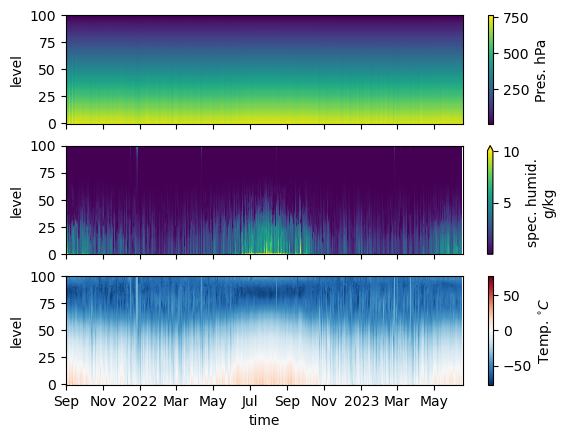

In [59]:
fig,ax=plt.subplots(3,1, sharex=True)

ds.pressure.plot(x='time', ax=ax[0], cbar_kwargs={"label":"Pres. hPa"})
(ds.q*1000).plot(x='time', ax=ax[1], vmax=10, cbar_kwargs={"label":"spec. humid.\ng/kg"})
ds.temp.plot(x='time',     ax=ax[2], cbar_kwargs={"label":r"Temp. $^{\circ}C$"})

for axx in ax.flatten():
    axx.set_yticks([0,25,50,75,100])

ax[0].set_xlabel("")
ax[1].set_xlabel("")

plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_rrtmg_input_data.png", dpi=600, bbox_inches='tight')

In [42]:
ds

<xarray.Dataset> Size: 76MB
Dimensions:    (level: 100, time: 15696)
Coordinates:
  * level      (level) float64 800B 0.0 1.0 2.0 3.0 4.0 ... 96.0 97.0 98.0 99.0
  * time       (time) datetime64[ns] 126kB 2021-09-01 ... 2023-06-16T23:00:00
Data variables:
    rh_scaled  (time, level) float64 13MB ...
    temp       (time, level) float64 13MB ...
    pressure   (time, level) float64 13MB ...
    r          (time, level) float64 13MB ...
    dp         (time) float64 126kB ...
    pwat       (time) float64 126kB ...
    q          (time, level) float64 13MB ...
    o3         (time, level) float64 13MB 0.056 0.05576 0.05488 ... 7.242 8.077
Attributes:
    long_name:            Relative humidity scaled using MWR
    units:                %
    valid_min:            0.0
    valid_max:            105.0
    ancillary_variables:  aqc_rh_scaled qc_rh_scaled vapor_source

In [30]:
#ds.to_netcdf("/global/homes/r/rudisill/gshare2/rrtmg_shared/atmos_data_sail.nc")

In [23]:
# https://acp.copernicus.org/articles/20/16089/2020/ --- this might be somewhat helpful for figinrout out AOD and where to put it 

#  A global-mean ozone climatology
def test_rrtmg_sw_clearsky(_COSZ,
                           _DYOFYR,
                            itime,
                            aod,
                            wsa_alb_nir,
                            bsa_alb_nir,
                            wsa_alb_vis,
                            bsa_alb_vis,  
                            aerosol_option = 6,
                           ):

    ######## MAKE INPUT DATA HERE ########
    # Specific heat at constant pressure
    cp = 1004.

    # Set up the pressure domain
    
    # RRTM code expects arrays with (ncol, nlay)
    # and with pressure decreasing from surface at element 0
    ptime = ds.isel(time=itime).pressure 
    pdp   = ds.isel(time=itime).dp
    ps    = ptime.values[0]   # ds.pressure.values[0] #  Surface pressure in hPa

    # layers 
    ncol = 1
    nlay = 100  # this is the number of layers. and there are nlay+1 number of interfaces

    #  pressure profile
    play = ptime.values[np.newaxis, ...] 
    plev = (ptime - .5*pdp).interp(level=np.linspace(0, nlay-1, nlay+1)).values[np.newaxis, ...]


    #  temperature profile
    tlay = ds.isel(time=itime).temp.values[np.newaxis, ...] + 273.15
    tsfc = tlay[0,0] + 1
    tlev = (ds.isel(time=itime).temp.interp(level=np.linspace(0, nlay-1, nlay+1)) + 273.15).values[np.newaxis, ...]

    #  Water vapor profile
    #r = ds.isel(time=itime).r.values 
    # q= r / (1 + r)
    specific_humidity = ds.isel(time=itime).q.values

    # Convert to volume mixing ratio from mass mixing ratio
    # just multiplying by ratio of molecular weights of dry air and H2O
    h2ovmr = specific_humidity * 28.97 / 18.01528
    h2ovmr = h2ovmr[np.newaxis, ...]

    # get ozone data 
    o3vmr  = ds.isel(time=itime).o3.values * 1E-7    #o3_interp[np.newaxis, :]* .1## THIS IS A GLOBAL DEFINED ABOVE 
    o3vmr  = o3vmr[np.newaxis, ...]
    # Other values taken from the AquaPlanet Experiment protocols,
    # except for O2 which is set the realistic value 0.21
    co2vmr   = 415.7 / 1E6 * np.ones_like(play)                 # https://gaw.kishou.go.jp/publications/global_mean_mole_fractions
    ch4vmr   = 1650. / 1E9 * np.ones_like(play)
    n2ovmr   = 306. / 1E9 * np.ones_like(play)
    o2vmr    = 0.21 * np.ones_like(play)
    cfc11vmr = 0. * np.ones_like(play)
    cfc12vmr = 0. * np.ones_like(play)
    cfc22vmr = 0. * np.ones_like(play)
    ccl4vmr  = 0. * np.ones_like(play)

    #  Cloud parameters --- WE ARE NOT USING CLOUDS HERE
    cloud_level_index = 8
    cldfrac = 0.5*np.exp(-(play-play[0,cloud_level_index])**2/(2*25.)**2)  # Layer cloud fraction: a Gaussian centered on a pressure level
    clwp    = 60. * np.ones_like(play)  # in-cloud liquid water path (g/m2)
    ciwp    = 0. * np.ones_like(play)   # in-cloud ice water path (g/m2)
    relq    = 14. * np.ones_like(play) # Cloud water drop effective radius (microns)
    reic    = 0. * np.ones_like(play)  # Cloud ice particle effective size (microns)
    
    ########## END MAKE INPUT DATA ##########
    #! naerec :  integer: number of aerosols (iaer=6, ecmwf aerosol option)
    #! ngptsw :  integer: total number of reduced g-intervals for rrtmg_lw
    nbndsw = int(rrtmg_sw.parrrsw.nbndsw)  #! nbndsw :  integer: number of spectral bands
    naerec = int(rrtmg_sw.parrrsw.naerec)  #! naerec :  integer: number of aerosols (iaer=6, ecmwf aerosol option)
    ngptsw = int(rrtmg_sw.parrrsw.ngptsw)  #! ngptsw :  integer: total number of reduced g-intervals for rrtmg_lw
    
    #  Initialize absorption data
    rrtmg_sw.climlab_rrtmg_sw_ini(cp)

    #  Lots of RRTMG parameters
    icld = 0             # Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random] 3: Maximum
    irng = 1             # more monte carlo stuff
    permuteseed = 150
    dyofyr = _DYOFYR    # day of the year used to get Earth/Sun distance (if not adjes)
    inflgsw  = 2        # ! Flag for cloud optical properties
    iceflgsw = 1        # ! Flag for ice particle specification
    liqflgsw = 1        # ! Flag for liquid droplet specification

    ##################
    # BEGIN AEROSOLS
    ##################
    iaer = aerosol_option    #! Aerosol option flag
                #!    0: No aerosol
                #!    6: ECMWF method: use six ECMWF aerosol types input aerosol optical depth at 0.55 microns for each aerosol type (ecaer)
                #!    10:Input aerosol optical properties: input total aerosol optical depth, single scattering albedo and asymmetry parameter (tauaer, ssaaer, asmaer) directly
    ##################
    # FOR IAER=10 ONLY
    ##################
    tauaer = 0. * np.ones_like(play)   # Aerosol optical depth (iaer=10 only), Dimensions,  (ncol,nlay,nbndsw)] #  (non-delta scaled)

    #  broadcast and transpose to get [ncol,nlay,nbndsw]
    tauaer = np.transpose(tauaer * np.ones([nbndsw,ncol,nlay]), (1,2,0))
    ssaaer = 0. * np.ones_like(play)   # Aerosol single scattering albedo (iaer=10 only), Dimensions,  (ncol,nlay,nbndsw)] #  (non-delta scaled)

    #  broadcast and transpose to get [ncol,nlay,nbndsw]
    ssaaer = np.transpose(ssaaer * np.ones([nbndsw,ncol,nlay]), (1,2,0))
    asmaer = 0. * np.ones_like(play)   # Aerosol asymmetry parameter (iaer=10 only), Dimensions,  (ncol,nlay,nbndsw)] #  (non-delta scaled)

    #  broadcast and transpose to get [ncol,nlay,nbndsw]
    asmaer = np.transpose(asmaer * np.ones([nbndsw,ncol,nlay]), (1,2,0))
    
    ##################
    # FOR IAER=6 ONLY
    ##################
    ecaer  = 0 * np.ones_like(play)   # Aerosol optical depth at 0.55 micron (iaer=6 only), Dimensions,  (ncol,nlay,naerec)] #  (non-delta scaled)

    #  broadcast and transpose to get [ncol,nlay,naerec]
    ecaer = np.transpose(ecaer * np.ones([naerec,ncol,nlay]), (1,2,0))
    
    # 0th column is continental background (right)
    # center is the pressure levels. 20 levels is about 600 hpa
    ecaer[0,:,0] = ecaer[0,:,0] + calculate_aod_profile(aod, nlay, .1) # this is what i had originally... not sure why? 7/(720-10)
    ecaer[0,:,2] = ecaer[0,:,2] + calculate_aod_profile(aod, nlay, .1) # this is what i had originally... not sure why? 7/(720-10)

    # !  1/ continental average                 2/ maritime
    # !  3/ desert                              4/ urban
    # !  5/ volcanic active                     6/ stratospheric background


#    ecaer[0,0:5,0] = ecaer[0,0:5,0] + aod/5

    ##################  
    # DONE WITH AEROSOLS
    ##################
    
    # insolation
    scon = 1365.2      # solar constant
    coszen = _COSZ     # cosine of zenith angle
    adjes = 0          # instantaneous irradiance = scon * eccentricity_factor

    # new arguments for RRTMG_SW version 4.0
    isolvar = 1    # ! Flag for solar variability method
                    # !   -1 = (when scon .eq. 0.0): No solar variability
                    # !        and no solar cycle (Kurucz solar irradiance
                    # !        of 1368.22 Wm-2 only);
                    # !        (when scon .ne. 0.0): Kurucz solar irradiance
                    # !        scaled to scon and solar variability defined
                    # !        (optional) by setting non-zero scale factors
                    # !        for each band in bndsolvar
                    # !    0 = (when SCON .eq. 0.0): No solar variability
                    # !        and no solar cycle (NRLSSI2 solar constant of
                    # !        1360.85 Wm-2 for the 100-50000 cm-1 spectral
                    # !        range only), with facular and sunspot effects
                    # !        fixed to the mean of Solar Cycles 13-24;
                    # !        (when SCON .ne. 0.0): No solar variability
                    # !        and no solar cycle (NRLSSI2 solar constant of
                    # !        1360.85 Wm-2 for the 100-50000 cm-1 spectral
                    # !        range only), is scaled to SCON
                    # !    1 = Solar variability (using NRLSSI2  solar
                    # !        model) with solar cycle contribution
                    # !        determined by fraction of solar cycle
                    # !        with facular and sunspot variations
                    # !        fixed to their mean variations over the
                    # !        average of Solar Cycles 13-24;
                    # !        two amplitude scale factors allow
                    # !        facular and sunspot adjustments from
                    # !        mean solar cycle as defined by indsolvar
                    # !    2 = Solar variability (using NRLSSI2 solar
                    # !        model) over solar cycle determined by
                    # !        direct specification of Mg (facular)
                    # !        and SB (sunspot) indices provided
                    # !        in indsolvar (scon = 0.0 only)
                    # !    3 = (when scon .eq. 0.0): No solar variability
                    # !        and no solar cycle (NRLSSI2 solar irradiance
                    # !        of 1360.85 Wm-2 only);
                    # !        (when scon .ne. 0.0): NRLSSI2 solar irradiance
                    # !        scaled to scon and solar variability defined
                    # !        (optional) by setting non-zero scale factors
                    # !        for each band in bndsolvar

    indsolvar = np.ones(2)      # Facular and sunspot amplitude scale factors (isolvar=1),
                                # or Mg and SB indices (isolvar=2)

    bndsolvar = np.ones(nbndsw)  # Solar variability scale factors for each shortwave band
    solcycfrac = 1.              # Fraction of averaged solar cycle (0-1) at current time (isolvar=1)

    # surface albedo
    aldif = wsa_alb_nir         # Near-IR bands 16-24 and 29 (1-9 and 14), 820-16000 cm-1, 0.625-12.195 microns
    aldir = bsa_alb_nir 
    asdif = wsa_alb_vis         # UV/visible bands 25-28 (10-13), 16000-50000 cm-1, 0.200-0.625 micron
    asdir = bsa_alb_vis

    # Clear-sky only
    cldfmcl = np.zeros((ngptsw,ncol,nlay))
    ciwpmcl = np.zeros((ngptsw,ncol,nlay))
    clwpmcl = np.zeros((ngptsw,ncol,nlay))
    reicmcl = np.zeros((ncol,nlay))
    relqmcl = np.zeros((ncol,nlay))
    taucmcl = np.zeros((ngptsw,ncol,nlay))
    ssacmcl = np.zeros((ngptsw,ncol,nlay))
    asmcmcl = np.zeros((ngptsw,ncol,nlay))
    fsfcmcl = np.zeros((ngptsw,ncol,nlay))

    (swuflx, swdflx, swhr, swuflxc, swdflxc, swhrc) = \
            rrtmg_sw.climlab_rrtmg_sw(ncol, nlay, icld, iaer,
                play, plev, tlay, tlev, tsfc,
                h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                asdir, asdif, aldir, aldif,
                coszen, adjes, dyofyr, scon, isolvar,
                inflgsw, iceflgsw, liqflgsw, cldfmcl,
                taucmcl, ssacmcl, asmcmcl, fsfcmcl,
                ciwpmcl, clwpmcl, reicmcl, relqmcl,
                tauaer, ssaaer, asmaer, ecaer,
                bndsolvar, indsolvar, solcycfrac)
    
    return swdflx


In [24]:
# naerec = rrtmg_sw.parrrsw.naerec
# ncol = 1 
# nlay = 100
# ptime = ds.isel(time=0).pressure
# play = ptime.values[np.newaxis, ...]
# ecaer  = 0 * np.ones_like(play)   # Aerosol optical depth at 0.55 micron (iaer=6 only), Dimensions,  (ncol,nlay,naerec)] #  (non-delta scaled)
#  broadcast and transpose to get [ncol,nlay,naerec]
# ecaer = np.transpose(ecaer * np.ones([naerec,ncol,nlay]), (1,2,0))
# ecaer.shape
# # 0th column is continental background
# #ecaer[0,:,0] = ecaer[0,:,0] + aod #* 7/(720-10)

In [25]:
#aod_array

In [26]:
from datetime import timedelta

In [27]:
ceres_matched = xr.DataArray(ceres_matched, dims=ceres_aod_sail.dims, coords=ceres_aod_sail.coords)

In [28]:
qcrad_cza = pd.read_csv('~/gshare2/will_data/crf_files/qcrad_cza_10min.csv', index_col=0, parse_dates=True)

In [136]:
cza_to_save = xr.Dataset({"cosine_solar_zenith_angle":qcrad_cza})

In [137]:
cza_to_save.attrs = {"units": "cosine of the solar zenith angle"}

In [139]:
cza_to_save.to_netcdf("/global/homes/r/rudisill/gshare2/rrtmg_shared/cosine_solar_zenith_angle.nc")

In [125]:
cza_to_save.to_netcdf("/global/homes/r/rudisill/gshare2/rrtmg_shared/cza_data.nc")

ValueError: unable to infer dtype on variable '__xarray_dataarray_variable__'; xarray cannot serialize arbitrary Python objects

In [39]:
dr = pd.date_range("2021-09-01", "2023-06-15", freq='10min')


In [30]:
latitude  = 38.956381  # ERW
longitude = -106.984322  # ERW

In [43]:
czax = np.array([calculate_solar_zenith_cosine(latitude, longitude, d + timedelta(minutes=10)) for d in dr]).clip(min=0)
cza = np.array(qcrad_cza[dr[0]:dr[-1]]['0'])


In [46]:
np.array(qcrad_cza[dr[0]:dr[-1]]['0'].clip(lower=0))

array([0.3163615 , 0.284118  , 0.25153264, ..., 0.517367  , 0.4882856 ,
       0.45875356])

In [41]:
cza

array([0.3163615 , 0.284118  , 0.25153264, ..., 0.517367  , 0.4882856 ,
       0.45875356])

In [29]:
latitude  = 38.956381  # ERW
longitude = -106.984322  # ERW


dr = pd.date_range("2021-09-01", "2023-06-15", freq='10min')
#dr = pd.date_range("2022-07-10", "2022-07-11", freq='10min')

cza = np.array([calculate_solar_zenith_cosine(latitude, longitude, d + timedelta(minutes=10)) for d in dr]).clip(min=0)
cza = np.array(qcrad_cza[dr[0]:dr[-1]]['0'])

def run_rrtmg_with_options(latitude=latitude,
                           longitude=longitude,
                           dr=dr,
                           cza=cza,
                           aod_array=ceres_matched,
                           albedox=albedo_ds,
                           aerosol_option=6,
                           ):
    
    assert len(dr) == len(cza)
    swdown    = np.zeros_like(cza)
    swdowntoa = np.zeros_like(cza)


    for k in range(1, len(cza)):
        date         =  dr[k]
        doy          =  dr[k].dayofyear
        aod55        =  aod_array.sel(time=date, method='nearest').values
#        alb          =  albedox.sel(time=date, method='nearest').best_albedo.values
        wsa_alb_nir  = albedo_ds['albedo_wsa_nir'].sel(time=date, method='nearest').values/1000
        bsa_alb_nir  = albedo_ds['albedo_bsa_nir'].sel(time=date, method='nearest').values/1000
        wsa_alb_vis  = albedo_ds['albedo_wsa_vis'].sel(time=date, method='nearest').values/1000
        bsa_alb_vis  = albedo_ds['albedo_bsa_vis'].sel(time=date, method='nearest').values/1000
        c            =  cza[k]

        # ## this gets the index of the dataset that is the closes to the given date
        # ## the "ds" is the dataset which is hourly.
        kvalue       =  (ds.time == ds.sel(time=date, method='nearest').time).argmax() 
        swdflx       =  test_rrtmg_sw_clearsky(c, 
                                               doy, 
                                               kvalue, 
                                               aod55, 
                                               wsa_alb_nir,
                                               bsa_alb_nir,
                                               wsa_alb_vis,
                                               bsa_alb_vis, 
                                               aerosol_option)

        swdown[k]    =  swdflx[0,0]
        swdowntoa[k] =  swdflx[0,-1] 

    # return stuff
    return swdown, swdowntoa


In [59]:
swdc_sfc, swdc_toa = run_rrtmg_with_options(aerosol_option=6)

In [48]:
swdc_sfc2, swdc_toa2 = run_rrtmg_with_options(aerosol_option=6)

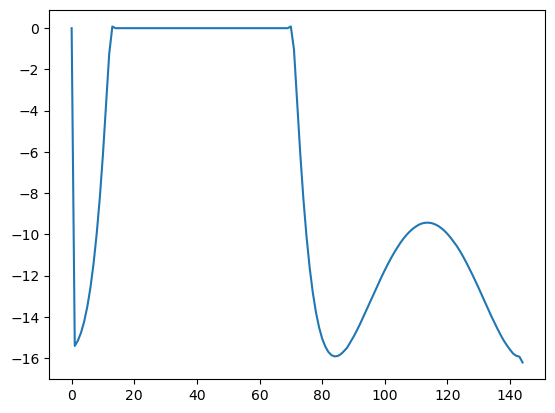

In [60]:
plt.plot(swdc_sfc - swdc_sfc2)

In [ ]:
#swdc_sfc_noaer, swdc_toa = run_rrtmg_with_options(aerosol_option=0)

In [ ]:
#swdcdf = pd.DataFrame({"time": dr, "swdc_toa": swdc_toa, 'swd':swdc_sfc, 'swd_no_aer':swdc_sfc_noaer})#, 'swd_no_aer':swdc_no_aer})
swdcdf = pd.DataFrame({"time": dr, "swdc_toa": swdc_toa, 'swd':swdc_sfc}) #'swd_no_aer':swdc_sfc_noaer})#, 'swd_no_aer':swdc_no_aer})
swdcdf = swdcdf.set_index("time")

In [ ]:
#swdcdf.to_csv("/global/homes/r/rudisill/gshare/sail_data_will/rrtmg/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0611.csv")
swdcdf.to_csv("/global/homes/r/rudisill/gshare/sail_data_will/rrtmg/rrtmgClearSkySW_and_M1Obs_SailPeriod_all_o3_ceresAer_0717.csv")